In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd 
import pdb
import time
import math
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop, Adam
from keras.models import model_from_json
from keras.callbacks import LearningRateScheduler 
import keras.callbacks as CB 
from keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
import scipy.misc

Using TensorFlow backend.


# Load Training Data

In [ ]:
#List of available computing units. If no gpu appears, access not working. CPU mode
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [ ]:
#GPU relevant code. Can be ignored in CPU mode
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
sess = tf.Session(config=config) 
K.backend.set_session(sess)

In [4]:
train = pd.read_json('C:/Users/Patri/Documents/Python Scripts/project cnn/input/train.json')
# for reproducibility
np.random.seed(1337)

In [5]:
def get_images(df):
    '''Create 3-channel 'images'. Return rescale-normalised images.'''
    images = []
    for i, row in df.iterrows():
        # Formulate the bands as 75x75 arrays
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        # Rescale
        r = (band_1 - band_1.min()) / (band_1.max() - band_1.min())
        g = (band_2 - band_2.min()) / (band_2.max() - band_2.min())
        b = (band_3 - band_3.min()) / (band_3.max() - band_3.min())

        rgb = np.dstack((r, g, b))
        images.append(rgb)
    return np.array(images)

In [6]:
X = get_images(train)

In [7]:
y = to_categorical(train.is_iceberg.values,num_classes=2)

In [8]:
Xtr, Xv, ytr, yv = train_test_split(X, y, shuffle=False, test_size=0.20)

# Define function to plot model accuracy

In [10]:
def plot_fig(i, history):
    """Plots model accuracy for each epoch. [i] defines the file number"""
    fig = plt.figure()
    plt.plot(range(1,epochs+1),history.history['val_acc'],label='validation')
    plt.plot(range(1,epochs+1),history.history['acc'],label='training')
    plt.legend(loc=0)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.xlim([1,epochs])
#     plt.ylim([0,1])
    plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()
    fig.savefig('C:/Users/Patri/Documents/Python Scripts/project cnn/img/'+str(i)+'-accuracy.png')
    plt.close(fig)

In [9]:
def ConvBlock(model, layers, filters):
    '''Create several layers with zero padding,convolution with specific amount of 3x3 filters and batch normalization. Max pooling after the last layer.'''
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
        model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [102]:
def ConvBlock_tanh(model, layers, filters):
    '''tanh experimental block'''
    for i in range(layers):
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(filters, (3, 3), activation='tanh'))
        model.add(BatchNormalization(axis=3))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Model definition

In [11]:
def create_model():
    '''FCN model'''

    model = Sequential()

    # Input image: 75x75x3
    model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
    ConvBlock(model, 1, 32)
    # 37x37x32
    ConvBlock(model, 1, 64)
    # 18x18x64
    ConvBlock(model, 1, 128)
    # 9x9x128
    ConvBlock(model, 1, 128)
    # 4x4x128
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(2, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    # 4x4x2
    model.add(Activation('softmax'))
    
    return model

In [103]:
def create_model_tanh():
    '''experimental FCN model'''

    model = Sequential()

    # Input image: 75x75x3
    model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
    ConvBlock(model, 1, 32)
    # 37x37x32
    ConvBlock(model, 1, 64)
    # 18x18x64
    ConvBlock(model, 1, 128)
    # 9x9x128
    #ConvBlock(model, 1, 128)
    # 4x4x128
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(2, (3, 3), activation='relu'))
    model.add(GlobalAveragePooling2D())
    # 4x4x2
    model.add(Activation('softmax'))
    
    return model

In [108]:
####EXPERIMENTAL MODEL - not used - take out before delivery

def createmodel2():
    """experimental block on different input values"""
    #Build keras model
    
    model=Sequential()
    #model.add(Dense(512, activation='sigmoid', input_shape=(784,)))
    #, activation='sigmoid',
    #model.add(Dense(512, activation=’tanh’, input_shape=(784,)))
    # CNN 1
    model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 2
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    # CNN 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #CNN 4
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    #flatten the data for the dense layers
    model.add(Flatten())

    #Dense 1
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.2))

    #Dense 2
    model.add(Dense(256, activation='tanh'))
    model.add(Dropout(0.2))

    # Output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = Adam(lr=0.001, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# init

In [55]:
batch_size=60
epochs=30
learning_rate=0.001

# constant learning rate

In [34]:
# define CNN model
model1 = create_model()#cnn_model()

# define SGD optimizer
sgd = SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False) # set to default except lr

# compile the model
model1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [35]:
start_time = time.time()

print ('lr = {}'.format(K.get_value(model1.optimizer.lr)))
# fit the model
history = model1.fit(Xtr, ytr, validation_data=(Xv, yv), batch_size=batch_size, epochs=epochs,verbose=1)

#init_epo += num_epo
#end_epo = init_epo + num_epo
elapsed_time = time.time() - start_time
print("elapsed time:",elapsed_time)

lr = 0.10000000149011612
Train on 1283 samples, validate on 321 samples
Epoch 1/20
1283/1283 [==============================] - 96s 75ms/step - loss: 0.6485 - acc: 0.5433 - val_loss: 0.6600 - val_acc: 0.6511
Epoch 2/20
1283/1283 [==============================] - 96s 75ms/step - loss: 0.5403 - acc: 0.6960 - val_loss: 1.7011 - val_acc: 0.3925
Epoch 3/20
1283/1283 [==============================] - 92s 72ms/step - loss: 0.4103 - acc: 0.7950 - val_loss: 4.8290 - val_acc: 0.6573
Epoch 4/20
1283/1283 [==============================] - 90s 70ms/step - loss: 0.3733 - acc: 0.8277 - val_loss: 1.8448 - val_acc: 0.4766
Epoch 5/20
1283/1283 [==============================] - 94s 73ms/step - loss: 0.3139 - acc: 0.8496 - val_loss: 0.7005 - val_acc: 0.6698
Epoch 6/20
1283/1283 [==============================] - 92s 71ms/step - loss: 0.2649 - acc: 0.8823 - val_loss: 0.7328 - val_acc: 0.6573
Epoch 7/20
1283/1283 [==============================] - 87s 68ms/step - loss: 0.2593 - acc: 0.8714 - val_loss: 0

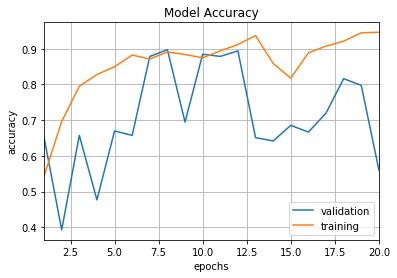

In [39]:
# plot model accuracy
plot_fig(1, history)

# Time-based decay

In [36]:

# define CNN model
model2 = create_model()

# define SGD optimizer
decay_rate = learning_rate / epochs
momentum = 0.5
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

# compile the model
model2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [37]:
start_time = time.time()

print ('lr = {}'.format(K.get_value(model2.optimizer.lr)))
history2 = model2.fit(Xtr, ytr, validation_data=(Xv, yv), batch_size=batch_size, epochs=epochs,verbose=2)

elapsed_time = time.time() - start_time
print("elapsed time:",elapsed_time)

lr = 0.10000000149011612
Train on 1283 samples, validate on 321 samples
Epoch 1/20
 - 89s - loss: 0.6416 - acc: 0.6516 - val_loss: 0.6814 - val_acc: 0.6947
Epoch 2/20
 - 89s - loss: 0.5243 - acc: 0.7568 - val_loss: 0.5048 - val_acc: 0.6386
Epoch 3/20
 - 89s - loss: 0.3966 - acc: 0.8129 - val_loss: 3.1017 - val_acc: 0.6573
Epoch 4/20
 - 87s - loss: 0.5157 - acc: 0.7186 - val_loss: 1.1477 - val_acc: 0.4455
Epoch 5/20
 - 87s - loss: 0.3206 - acc: 0.8504 - val_loss: 1.1111 - val_acc: 0.5016
Epoch 6/20
 - 89s - loss: 0.2987 - acc: 0.8652 - val_loss: 0.7231 - val_acc: 0.7040
Epoch 7/20
 - 88s - loss: 0.2915 - acc: 0.8597 - val_loss: 0.6129 - val_acc: 0.7477
Epoch 8/20
 - 88s - loss: 0.2554 - acc: 0.8753 - val_loss: 0.3684 - val_acc: 0.8598
Epoch 9/20
 - 86s - loss: 0.2599 - acc: 0.8862 - val_loss: 0.3247 - val_acc: 0.8505
Epoch 10/20
 - 90s - loss: 0.2291 - acc: 0.9026 - val_loss: 1.2008 - val_acc: 0.6667
Epoch 11/20
 - 88s - loss: 0.2543 - acc: 0.8854 - val_loss: 0.6982 - val_acc: 0.7352
Ep

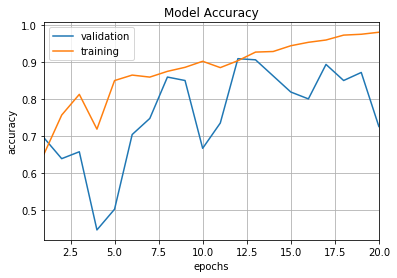

In [38]:
# plot model accuracy
plot_fig(2, history2)

# Step decay

In [77]:
# define CNN model
model3 = create_model()

# define SGD optimizer
momentum = 0.5
sgd = SGD(lr=0.0, momentum=momentum, decay=0.0, nesterov=False) 

# compile the model
model3.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

# define step decay function
class LossHistory(CB.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))
        print('lr:', step_decay(len(self.losses)))

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# learning schedule callback
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)
callbacks_list = [loss_history, lrate]




Train on 1283 samples, validate on 321 samples
Epoch 1/20
 - 95s - loss: 0.6945 - acc: 0.5261 - val_loss: 0.7063 - val_acc: 0.6916
lr: 0.1
Epoch 2/20
 - 93s - loss: 0.5746 - acc: 0.7093 - val_loss: 0.8778 - val_acc: 0.5794
lr: 0.1
Epoch 3/20
 - 102s - loss: 0.5477 - acc: 0.7475 - val_loss: 0.9504 - val_acc: 0.5607
lr: 0.1
Epoch 4/20
 - 108s - loss: 0.5206 - acc: 0.7560 - val_loss: 3.4744 - val_acc: 0.6511
lr: 0.1
Epoch 5/20
 - 107s - loss: 0.4215 - acc: 0.7896 - val_loss: 2.2665 - val_acc: 0.6573
lr: 0.1
Epoch 6/20
 - 107s - loss: 0.3829 - acc: 0.8153 - val_loss: 0.7852 - val_acc: 0.6667
lr: 0.1
Epoch 7/20
 - 107s - loss: 0.3448 - acc: 0.8270 - val_loss: 0.6454 - val_acc: 0.6854
lr: 0.1
Epoch 8/20
 - 107s - loss: 0.3165 - acc: 0.8550 - val_loss: 0.3681 - val_acc: 0.8255
lr: 0.1
Epoch 9/20
 - 108s - loss: 0.2679 - acc: 0.8753 - val_loss: 0.3651 - val_acc: 0.8442
lr: 0.1
Epoch 10/20
 - 106s - loss: 0.2609 - acc: 0.8815 - val_loss: 0.3501 - val_acc: 0.8567
lr: 0.05
Epoch 11/20
 - 107s - l

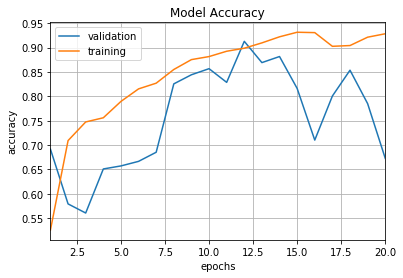

ValueError: Format 'jpg' is not supported (supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz)

In [21]:
start_time = time.time()

history3 = model3.fit(Xtr, ytr, validation_data=(Xv, yv), batch_size=batch_size, epochs=epochs,verbose=2, callbacks=callbacks_list)

elapsed_time = time.time() - start_time
print("elapsed time:",elapsed_time)
# plot model accuracy



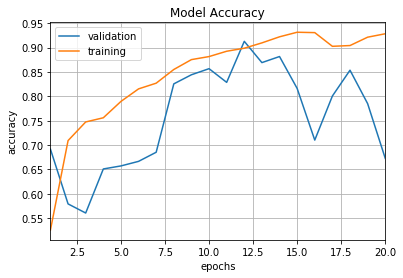

In [25]:
plot_fig(3, history3)

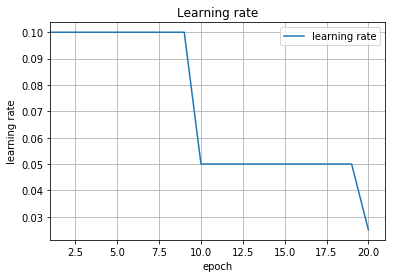

In [26]:
# plot learning rate
fig = plt.figure()
plt.plot(range(1,epochs+1),loss_history.lr,label='learning rate')
plt.xlabel("epoch")
plt.xlim([1,epochs+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()
fig.savefig('C:/Users/Patri/Documents/Python Scripts/project cnn/img/3-learning-rate.png')
plt.close(fig)

# Exponential decay

In [113]:
# define CNN model
#model4 = create_model()
model4=create_model()
# define SGD optimizer
momentum = 0.8
sgd = SGD(lr=0.0, momentum=momentum, decay=0.0, nesterov=False)

# compile the model
model4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# define step decay function
class LossHistory_(CB.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)
callbacks_list_ = [loss_history_, lrate_]


In [114]:
summary(model4)

NameError: name 'summary' is not defined

In [112]:
start_time = time.time()

# fit the model
history4 = model4.fit(Xtr, ytr, validation_data=(Xv, yv), 
     epochs=epochs, 
     batch_size=batch_size, 
     callbacks=callbacks_list_, 
     verbose=2)

elapsed_time = time.time() - start_time
print("elapsed time:",elapsed_time)


Train on 1283 samples, validate on 321 samples
Epoch 1/30
 - 88s - loss: 0.7253 - acc: 0.5230 - val_loss: 0.6927 - val_acc: 0.6542
lr: 0.09048374180359596
Epoch 2/30
 - 82s - loss: 0.6730 - acc: 0.5074 - val_loss: 0.6913 - val_acc: 0.6231
lr: 0.0818730753077982
Epoch 3/30
 - 82s - loss: 0.6453 - acc: 0.5183 - val_loss: 0.6064 - val_acc: 0.7040
lr: 0.0740818220681718
Epoch 4/30
 - 83s - loss: 0.5916 - acc: 0.6921 - val_loss: 0.5752 - val_acc: 0.7570
lr: 0.06703200460356394
Epoch 5/30
 - 81s - loss: 0.5015 - acc: 0.7872 - val_loss: 0.5369 - val_acc: 0.7882
lr: 0.06065306597126335
Epoch 6/30
 - 83s - loss: 0.4762 - acc: 0.7942 - val_loss: 0.5775 - val_acc: 0.7570
lr: 0.05488116360940264
Epoch 7/30
 - 84s - loss: 0.4921 - acc: 0.7740 - val_loss: 0.5044 - val_acc: 0.7601
lr: 0.04965853037914095
Epoch 8/30
 - 82s - loss: 0.4349 - acc: 0.8246 - val_loss: 0.5093 - val_acc: 0.7477
lr: 0.044932896411722156
Epoch 9/30
 - 78s - loss: 0.4194 - acc: 0.8005 - val_loss: 0.4437 - val_acc: 0.8037
lr: 0.

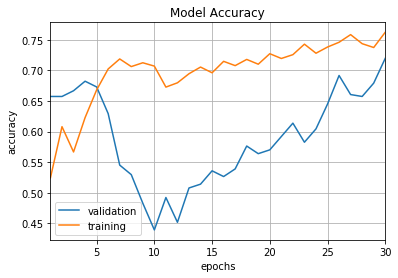

In [107]:
# plot model accuracy
plot_fig(4, history4)

In [52]:
# plot learning rate
fig = plt.figure()
plt.plot(range(1,epochs+1),loss_history_.lr,label='learning rate')
plt.xlabel("epoch")
plt.xlim([1,epochs+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()
fig.savefig('C:/Users/Patri/Documents/Python Scripts/project cnn/img/4-learning-rate.png')
plt.close(fig)

AttributeError: 'LossHistory_' object has no attribute 'lr'

<Figure size 432x288 with 0 Axes>

# Adaptive gradient descent algorithms : Adagrad, Adadelta, RMSprop, Adam

In [30]:
# fit CNN model using Adagrad optimizer
model5 = create_model()
model5.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(lr=learning_rate, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

history5 = model5.fit(Xtr, ytr, validation_data=(Xv, yv), 
     epochs=epochs, 
     batch_size=batch_size, 
     verbose=2)

# fit CNN model using Adadelta optimizer
model6 = create_model()
model6.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

history6 = model6.fit(Xtr, ytr, validation_data=(Xv, yv), 
     epochs=epochs, 
     batch_size=batch_size, 
     verbose=2)


Train on 1283 samples, validate on 321 samples
Epoch 1/20
 - 85s - loss: 0.6011 - acc: 0.7030 - val_loss: 0.8026 - val_acc: 0.6168
Epoch 2/20
 - 84s - loss: 0.4297 - acc: 0.7779 - val_loss: 1.2884 - val_acc: 0.5763
Epoch 3/20
 - 85s - loss: 0.4133 - acc: 0.7997 - val_loss: 0.5334 - val_acc: 0.6822
Epoch 4/20
 - 97s - loss: 0.3494 - acc: 0.8246 - val_loss: 0.4191 - val_acc: 0.8287
Epoch 5/20
 - 98s - loss: 0.3163 - acc: 0.8441 - val_loss: 2.5073 - val_acc: 0.4143
Epoch 6/20
 - 91s - loss: 0.3525 - acc: 0.8277 - val_loss: 0.4367 - val_acc: 0.8131
Epoch 7/20
 - 86s - loss: 0.2804 - acc: 0.8636 - val_loss: 0.4734 - val_acc: 0.7259
Epoch 8/20
 - 85s - loss: 0.2563 - acc: 0.8722 - val_loss: 0.2984 - val_acc: 0.8816
Epoch 9/20
 - 87s - loss: 0.2454 - acc: 0.8698 - val_loss: 0.8895 - val_acc: 0.5919
Epoch 10/20
 - 98s - loss: 0.2715 - acc: 0.8504 - val_loss: 0.4273 - val_acc: 0.8162
Epoch 11/20
 - 97s - loss: 0.2201 - acc: 0.8924 - val_loss: 3.1468 - val_acc: 0.6480
Epoch 12/20
 - 97s - loss: 

NameError: name 'cnn_model' is not defined

In [14]:
# fit CNN model using RMSprop optimizer
model7 = create_model()
model7.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=learning_rate, rho=0.9, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

history7 = model7.fit(Xtr, ytr, validation_data=(Xv, yv), 
     epochs=epochs, 
     batch_size=batch_size, 
     verbose=2)


Train on 1283 samples, validate on 321 samples
Epoch 1/20
 - 91s - loss: 0.5410 - acc: 0.7241 - val_loss: 0.5312 - val_acc: 0.6791
Epoch 2/20
 - 93s - loss: 0.3612 - acc: 0.8200 - val_loss: 0.4568 - val_acc: 0.6916
Epoch 3/20
 - 91s - loss: 0.3093 - acc: 0.8620 - val_loss: 0.4741 - val_acc: 0.7601
Epoch 4/20
 - 90s - loss: 0.2728 - acc: 0.8683 - val_loss: 0.3650 - val_acc: 0.8879
Epoch 5/20
 - 89s - loss: 0.2336 - acc: 0.8846 - val_loss: 0.3323 - val_acc: 0.8567
Epoch 6/20
 - 88s - loss: 0.2041 - acc: 0.9096 - val_loss: 0.3097 - val_acc: 0.8754
Epoch 7/20
 - 88s - loss: 0.1741 - acc: 0.9205 - val_loss: 0.3594 - val_acc: 0.8474
Epoch 8/20
 - 87s - loss: 0.1371 - acc: 0.9439 - val_loss: 0.3561 - val_acc: 0.8567
Epoch 9/20
 - 89s - loss: 0.1173 - acc: 0.9540 - val_loss: 0.4695 - val_acc: 0.8037
Epoch 10/20
 - 89s - loss: 0.0947 - acc: 0.9626 - val_loss: 0.3970 - val_acc: 0.8536
Epoch 11/20
 - 89s - loss: 0.0502 - acc: 0.9860 - val_loss: 0.3350 - val_acc: 0.8692
Epoch 12/20
 - 89s - loss: 

In [ ]:

# fit CNN model using Adam optimizer
model8 = create_model()
model8.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['accuracy'])

history8 = model8.fit(Xtr, ytr, validation_data=(Xv, yv), 
     epochs=epochs, 
     batch_size=batch_size, 
     verbose=2)

# cyclic learning rate

In [83]:
model9=create_model()

In [84]:
from keras.callbacks import *
#folder CLR, file clr_callback
from CLR.clr_callback import *

#using the triangular learning rate policy and
#  base_lr (initial learning rate which is the lower boundary in the cycle) is 0.1
clr_triangular = CyclicLR(mode='triangular')

model9.compile(optimizer=Adam(0.1), loss='categorical_crossentropy', metrics=['accuracy'])

#pass on this clr_triangular to the callbacks parameter while fitting the network. 
#You will use a larger batch_size this time. You will record the time as well.


In [85]:
model9.fit(Xtr, ytr, validation_data=(Xv, yv), epochs=14, batch_size=60, callbacks=[clr_triangular, loss_history], verbose=2)

# Final evaluation of the model
scores = model9.evaluate(Xv, yv, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 1283 samples, validate on 321 samples
Epoch 1/14
 - 87s - loss: 0.5820 - acc: 0.7124 - val_loss: 0.8382 - val_acc: 0.5234
lr: 0.1
Epoch 2/14


KeyboardInterrupt: 

In [79]:
# Final evaluation of the model
scores = model9.evaluate(Xtr, ytr, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 19.10%


ValueError: x and y must have same first dimension, but have shapes (30,) and (14,)

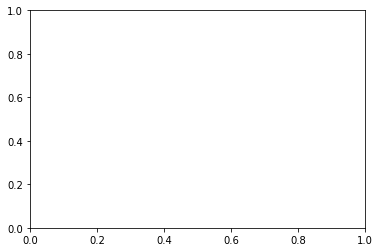

In [80]:
# plot learning rate
fig = plt.figure()
plt.plot(range(1,epoches+1),loss_history.lr,label='learning rate')
plt.xlabel("epoch")
plt.xlim([1,epoches+1])
plt.ylabel("learning rate")
plt.legend(loc=0)
plt.grid(True)
plt.title("Learning rate")
plt.show()
fig.savefig('C:/Users/Patri/Documents/Python Scripts/project cnn/img/9-learning-rate.png')
plt.close(fig)


# compare model accuracy

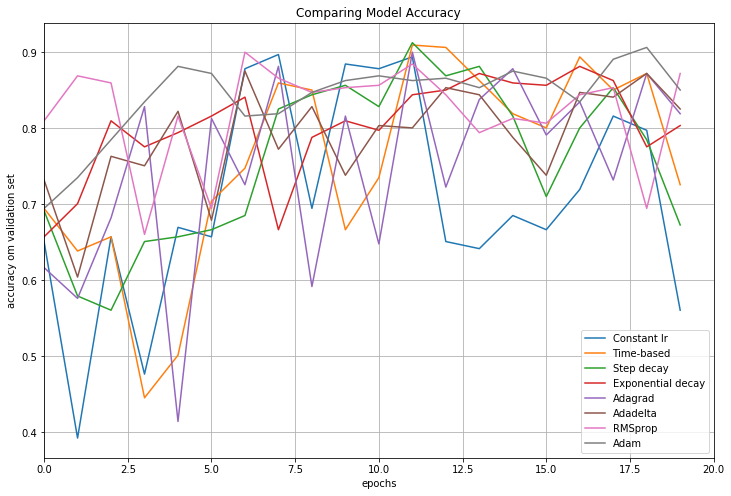

In [43]:
fig = plt.figure(figsize=(12,8))
plt.plot(range(epochs),history.history['val_acc'],label='Constant lr')
plt.plot(range(epochs),history2.history['val_acc'],label='Time-based')
plt.plot(range(epochs),history3.history['val_acc'],label='Step decay')
plt.plot(range(epochs),history4.history['val_acc'],label='Exponential decay')
plt.plot(range(epochs),history5.history['val_acc'],label='Adagrad')
plt.plot(range(epochs),history6.history['val_acc'],label='Adadelta')
plt.plot(range(epochs),history7.history['val_acc'],label='RMSprop')
plt.plot(range(epochs),history8.history['val_acc'],label='Adam')
plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('accuracy om validation set')
plt.grid(True)
plt.title("Comparing Model Accuracy")
plt.show()
fig.savefig('C:/Users/Patri/Documents/Python Scripts/project cnn/img/compare-accuracy.png')
plt.close(fig)

# Finish of learning decay and optimizer test

In [12]:
#model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 75, 75, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
__________

# Train Network


# Heat maps
The FCN will learn to distinguish between boats and icebergs using the final 2 4x4 channels. Each 4x4 channel represents one of the classes. Overlaying the 4x4 channel for each class on the image produces a heat map showing the "boatness" or the "bergness" of each section of the 4x4 grid.

In [15]:
l = model7.layers
conv_fn = K.function([l[0].input, K.learning_phase()], [l[-4].output])

In [21]:
def get_cm(inp, label):
    '''Convert the 4x4 layer data to a 75x75 image.'''
    conv = np.rollaxis(conv_fn([inp,0])[0][0],2,0)[label]
    return scipy.misc.imresize(conv, (75,75), interp='nearest')

In [22]:
def info_img (im_idx):
    '''heat maps for the boat (boatness) and iceberg (bergness) for image im_idx.'''
    if (yv[im_idx][1] == 1.0):
        img_type = 'iceberg'
    else:
        img_type = 'boat'
    inp = np.expand_dims(Xv[im_idx], 0)
    img_guess = np.round(model7.predict(inp)[0],2)
    if (img_guess[1] > 0.5):
        guess_type = 'iceberg'
    else:
        guess_type = 'boat'
    cm0 = get_cm(inp, 0)
    cm1 = get_cm(inp, 1)
    print ('truth: {}'.format(img_type))
    print ('guess: {}, prob: {}'.format(guess_type, img_guess))
    plt.figure(1,figsize=(10,10))
    plt.subplot(121)
    plt.title('Boatness')
    plt.imshow(Xv[im_idx])
    plt.imshow(cm0, cmap="cool", alpha=0.5)
    plt.subplot(122)
    plt.title('Bergness')
    plt.imshow(Xv[im_idx])
    plt.imshow(cm1, cmap="cool", alpha=0.5)

C:\Users\Patri\Anaconda3\envs\iceberg3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


truth: iceberg
guess: iceberg, prob: [0. 1.]


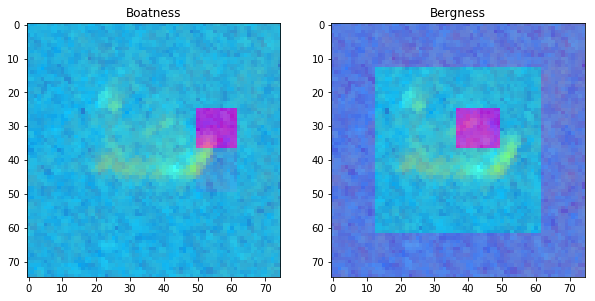

In [38]:

info_img(121)

In [ ]:
test = pd.read_json('C:/Users/Patri/Documents/Python Scripts/project cnn/input/test.json')
Xtest = get_images(test)
test_predictions = model.predict_proba(Xtest)
submission = pd.DataFrame({'id': test['id'], 'is_iceberg': test_predictions[:, 1]})
submission.to_csv('sub_fcn.csv', index=False)

In [ ]:
submission.head(5)

# submission - delete before delivery

In [ ]:
df_test = pd.read_json('C:/Users/Patri/Documents/Python Scripts/project cnn/input/test.json')
df_test.inc_angle = df_test.inc_angle.replace('na',0)
Xtest = (get_scaled_imgs(df_test))
pred_test = model4.predict(Xtest)

submission = pd.DataFrame({'id': df_test["id"], 'is_iceberg': pred_test.reshape((pred_test.shape[0]))})
print(submission.head(10))

submission.to_csv('submission.csv', index=False)

# TO DO:
    #Confusion matrix implementation 

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model4.predict(XVal)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred_ohe, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_true_labels, y_pred=y_pred_labels)  # shape=(12, 12)